## 1) Setup: imports & env


In [13]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
# make sure repo root is in sys.path
ROOT = Path('..')
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
import torch
from torch.utils.data import DataLoader
from src.datasets import SequenceDataset
from src.train import build_model, Trainer, set_seed
print('torch:', torch.__version__)
print('cuda available:', torch.cuda.is_available())


torch: 2.7.1+cu126
cuda available: False


## 2) Quick dataset sanity check

In [14]:
# Notebook cell
features_csv = '../data/processed/features_scaled.csv'
targets_csv = '../data/processed/targets.csv'
# lookback must match preprocessing (default 60)
LOOKBACK = 60
train_ds = SequenceDataset(features_csv, targets_csv, lookback=LOOKBACK,
split='train')
val_ds = SequenceDataset(features_csv, targets_csv, lookback=LOOKBACK,
split='val')
print('train samples:', len(train_ds))
print('val samples:', len(val_ds))
# show one sample shapes
x, y, d = train_ds[0]
print('x.shape:', x.shape, 'y.shape:', y.shape)


train samples: 1798
val samples: 207
x.shape: torch.Size([60, 36]) y.shape: torch.Size([6])


## 3) Train a model (LSTM example)


In [15]:
# Notebook cell
set_seed(42)

BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

n_features = train_ds.n_features
n_outputs = train_ds.n_targets

from src.train import LSTMModel
model = LSTMModel(
    n_features=n_features,
    n_outputs=n_outputs,
    hidden_size=50,
    n_layers=2,
    dropout=0.2
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = torch.nn.MSELoss()

trainer = Trainer(model, device, optimizer, criterion, Path('../results/checkpoints/lstm'), patience=10)
trainer.fit(train_loader, val_loader, epochs=EPOCHS)


Epoch 001 | train_loss=0.001999 | val_loss=0.000085 | time=0.9s
  Saved best checkpoint -> ../results/checkpoints/lstm/best.pth
Epoch 002 | train_loss=0.000413 | val_loss=0.000046 | time=1.0s
  Saved best checkpoint -> ../results/checkpoints/lstm/best.pth
Epoch 003 | train_loss=0.000315 | val_loss=0.000044 | time=1.0s
  Saved best checkpoint -> ../results/checkpoints/lstm/best.pth
Epoch 004 | train_loss=0.000249 | val_loss=0.000040 | time=0.9s
  Saved best checkpoint -> ../results/checkpoints/lstm/best.pth
Epoch 005 | train_loss=0.000222 | val_loss=0.000039 | time=1.6s
  Saved best checkpoint -> ../results/checkpoints/lstm/best.pth
Epoch 006 | train_loss=0.000195 | val_loss=0.000037 | time=2.0s
  Saved best checkpoint -> ../results/checkpoints/lstm/best.pth
Epoch 007 | train_loss=0.000183 | val_loss=0.000037 | time=2.0s
  Saved best checkpoint -> ../results/checkpoints/lstm/best.pth
Epoch 008 | train_loss=0.000169 | val_loss=0.000035 | time=2.1s
  Saved best checkpoint -> ../results/ch

## 4) Plot training history

/tmp/ipykernel_49051/390834854.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


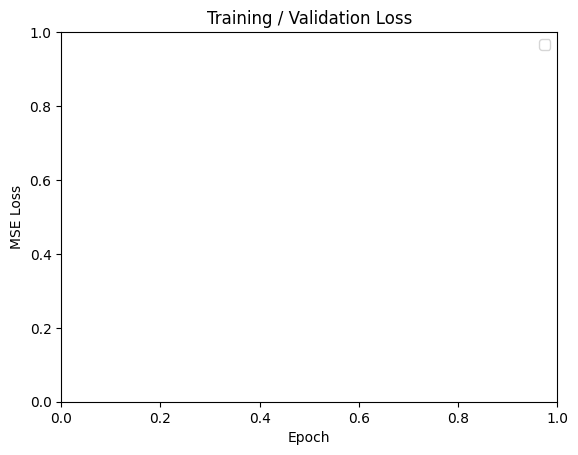

In [18]:
# Notebook cell
# If you ran the CLI version you may need to load logs; here we'll emulate by re-evaluating
# and plotting the losses available in Trainer if run interactively.
# For convenience, run training interactively in this notebook (as above) to capture losses.
# Example plot if you have losses recorded in `trainer` during this session:
if hasattr(trainer, 'train_losses'):
    plt.plot(trainer.train_losses, label='train')
if hasattr(trainer, 'val_losses'):
    plt.plot(trainer.val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training / Validation Loss')
plt.show()


## 5) Load best checkpoint & evaluate on validation set (RMSE & Directional Accuracy)


In [20]:
# Notebook cell
ckpt_path = Path('../results/checkpoints/lstm/best.pth')
assert ckpt_path.exists(), 'Checkpoint not found. Train first.'
ckpt = torch.load(ckpt_path, map_location='cpu')
3
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()
# evaluation helper
from sklearn.metrics import mean_squared_error
def evaluate_model(loader, model, device):
    y_true = []
    y_pred = []
    dates = []
    with torch.no_grad():
        for xb, yb, dt in loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            y_true.append(yb.numpy())
            y_pred.append(preds)
            dates.extend(list(dt))
            
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
# directional accuracy: proportion of matching signs averaged across assets/days

    dir_acc = (np.sign(y_true) == np.sign(y_pred)).mean()
    return dict(rmse=rmse, dir_acc=dir_acc, y_true=y_true, y_pred=y_pred,dates=dates)
    
res = evaluate_model(val_loader, model, device)
print('Validation RMSE (daily):', res['rmse'])
print('Validation directional accuracy:', res['dir_acc'])


Validation RMSE (daily): 0.005845284
Validation directional accuracy: 0.5370370370370371


## 6) Save predictions for downstream backtest


In [21]:
# Notebook cell
# Save val predictions with dates for debugging/backtest integration
pred_df = pd.DataFrame(res['y_pred'], index=res['dates'],
columns=pd.read_csv('../data/processed/targets.csv', index_col=0).columns)
pred_df.to_csv('../results/val_predictions_lstm.csv')
print('Saved val predictions to results/val_predictions_lstm.csv')


Saved val predictions to results/val_predictions_lstm.csv


## 7) Repeat for Transformer


In [23]:
# Notebook cell
# Instantiate Transformer and repeat training/evaluation steps above (changecheckpoint path)
from src.train import TransformerModel
model = TransformerModel(n_features=n_features, n_outputs=n_outputs, d_model=64,
n_heads=8, num_layers=2, dim_feedforward=128, dropout=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
trainer = Trainer(model, device, optimizer, criterion, Path('../results/checkpoints/transformer'), patience=10)

trainer.fit(train_loader, val_loader, epochs=EPOCHS)

# load & evaluate like before
ckpt_path = Path('../results/checkpoints/transformer/best.pth')
ckpt = torch.load(ckpt_path, map_location='cpu')
model.load_state_dict(ckpt['model_state_dict'])
res_tf = evaluate_model(val_loader, model, device)
print('Transformer val RMSE:', res_tf['rmse'], 'dir_acc:', res_tf['dir_acc'])


Epoch 001 | train_loss=0.007059 | val_loss=0.000674 | time=3.6s
  Saved best checkpoint -> ../results/checkpoints/transformer/best.pth
Epoch 002 | train_loss=0.000503 | val_loss=0.000390 | time=3.9s
  Saved best checkpoint -> ../results/checkpoints/transformer/best.pth
Epoch 003 | train_loss=0.000420 | val_loss=0.000232 | time=6.1s
  Saved best checkpoint -> ../results/checkpoints/transformer/best.pth
Epoch 004 | train_loss=0.000351 | val_loss=0.000333 | time=6.6s
Epoch 005 | train_loss=0.000376 | val_loss=0.000278 | time=7.6s
Epoch 006 | train_loss=0.000350 | val_loss=0.000176 | time=6.1s
  Saved best checkpoint -> ../results/checkpoints/transformer/best.pth
Epoch 007 | train_loss=0.000301 | val_loss=0.000101 | time=6.2s
  Saved best checkpoint -> ../results/checkpoints/transformer/best.pth
Epoch 008 | train_loss=0.000298 | val_loss=0.000221 | time=6.3s
Epoch 009 | train_loss=0.000283 | val_loss=0.000185 | time=7.4s
Epoch 010 | train_loss=0.000248 | val_loss=0.000110 | time=5.8s
Epoch